# 1-st order ODE
$$ \dfrac{d^2 y}{d x^2} = f(x) \\ \\  y(0) = y_{0}, \dfrac{d y}{d x} (0) = y_{0}^{'} $$

Assume, that $ y_0, y_0^{'} $ - fuzzy number. For convenience, membership function of $ a $ is triangular function.
Of course, we can solve it equation, for every $ \alpha - cut $ : $ \left ( a_{left}^i, a_{right}^i \right ) $

Numerical solution of this equation in simpliest way is euler-scheme : $ y_{i + 1} = {\Delta x}^2 f(x, y_{i}) + 2 y_{i} - y_{i - 1} $ and from derevative approximation : $ y_1 = y_{0}^{'} \Delta x + y_{0} $

In [1]:
%matplotlib inline  
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def f(_x):
    return 0.1

In [4]:
X = 1
steps = 20
y_0, y_1 = 2, -1

h_x = X / steps
x = np.linspace(0, X, steps)
y = np.zeros(steps)

y[0] = y_0
y[1] = h_x * y_1 + y_0

In [5]:
for i in range(2, steps):
    y[i] = h_x ** 2 * f(x[i]) + 2 * y[i - 1] - y[i - 2]

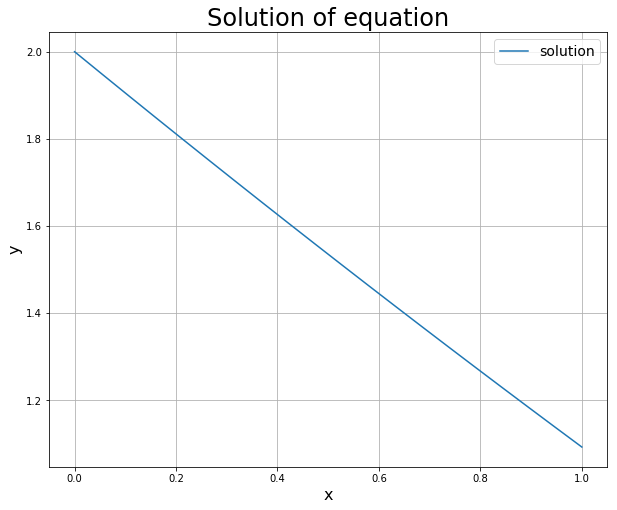

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(x, y, label='solution')
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Solution of equation', fontsize=24)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [234]:
import skfuzzy

In [195]:
import fuzzy_nums
from fuzzy_nums import FuzzyNumber
from fuzzy_nums.MFs import TrapMF, TriMF
from fuzzy_nums.Arithmetics import ArithmeticController

In [255]:
sections = 250
f1, f2 = FuzzyNumber(sections=sections), FuzzyNumber(sections=sections)
arithmetic_controller = ArithmeticController()
mf_1 = TriMF(y_0 * 0.9, y_0, y_0 * 1.1)
mf_2 = TriMF(y_1 * 0.9, y_1, y_1 * 1.1)

f1.set_mf(mf_1)
f2.set_mf(mf_2)

In [256]:
y = list()
y.append(f1)

f3 = f1 * h_x + f2

y.append(f3)

In [257]:
for i in range(2, steps):
    
    f1 = y[i - 2]
    f2 = y[i - 1]
    
    z = f1 + f2
    z = z * (-1) + h_x ** 2 * f(x[i])
    y.append(z)

In [258]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

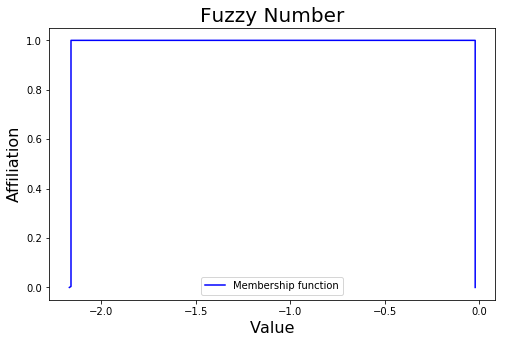

In [263]:
y[5].plot_mf()

# C-Means

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel('data.xls')
data.head()

,среднее Q за янв /среднее Q за год,среднее Q за июль/среднее Q за год
1. Дно,1.941622,0.369397
2.Полоное,1.379451,1.993568
3.Порхов,2.076521,2.587843
4.Дедовичи,1.249001,1.652473
5.Бежаницы,2.374301,2.968931


In [4]:
Q = data.values[:, 0:]

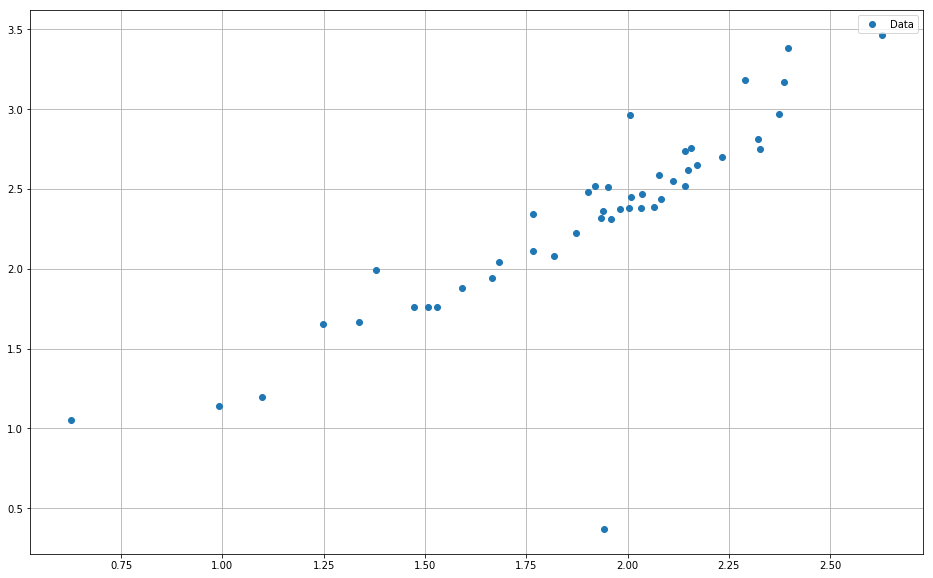

In [5]:
plt.figure(figsize=(16, 10))
plt.plot(Q[:, 0], Q[:, 1], 'o', label='Data')
plt.grid()
plt.legend()
plt.show()

In [6]:
def FCM(observations, clusters=3, tol=1e-3, max_iter=25, power=2):
    
    u = np.random.uniform(low=0, high=1, size=(observations.shape[0], clusters))
    centers = np.zeros((clusters, observations.shape[1]))
    
    def update_centers(observations, u, centers, power=1):
        rows, cols = u.shape
        for j in range(cols):
            c_j = observations[0, :] * np.power(u[0, j], power)
            for i in range(1, rows):
                c_j += observations[i, :] * np.power(u[i, j], power)
                
            c_j /= np.sum(np.power(u[:, j], power))
            
            centers[j, :] = c_j
        
        return centers
    
    def update_mf_matrix(observations, u, centers, power=1):
        classes = np.zeros(observations.shape[0])
        rows, cols = u.shape
        for i in range(rows):
            for j in range(cols):
                x = observations[i, :]
                c_i = centers[j, :]
                
                over_part = np.linalg.norm(x - c_i)
                
                result = 0
                for k in range(clusters):
                    c_k = centers[k, :]
                    
                    add = over_part / np.linalg.norm(x - c_k)
                    add = np.power(add, power)
                    result += add
                
                u[i, j] = 1 / result
                
            classes[i] = np.argmax(u[i, :])
            
        return u, classes
    
    def loss(observations, u, centers, power=1):
        rows, cols = u.shape
        _loss = 0
        for i in range(rows):
            for j in range(cols):
                x = observations[i, :]
                c = centers[j, :]
                l = np.power(u[i, j], power) * np.linalg.norm(x - c) ** 2
                
                _loss += l
                
        return _loss
    
    err = 1
    iteration = 1
    
    errors = [loss(observations, u, centers, power=0)]
    
    while err > tol and iteration < max_iter:

        centers = update_centers(observations, u, centers, power=power)
        u, classes = update_mf_matrix(observations, u, centers, power=2 / (power))
        l = loss(observations, u, centers, power=power)
        
        errors.append(l)
        
        err = np.abs(l)
        iteration += 1
    
    errors = np.array(errors)
    
    return classes, centers, u, errors

In [7]:
def plot_FCM_results(data, max_clusters=4):
    
    fig, axs = plt.subplots(nrows=np.int(max_clusters / 2), ncols=2)
    fig.set_figwidth(16)
    fig.set_figheight(8 * max_clusters // 2)
    
    mfs = []
    
    for clusters, ax in zip(range(1, max_clusters + 1), axs.flatten()):
        classes, centers, u, errors = FCM(data, clusters=clusters, tol=1e-5, max_iter=100)
        
        mfs.append((clusters, u))
        
        for cluster in range(clusters):
            cluster_data = data[np.where(classes == cluster), :][0]
            ax.plot(cluster_data[:, 0], cluster_data[:, 1], 'o', label='Cluster {}'.format(cluster + 1))
        ax.legend()
        ax.grid()
    
    plt.show()
    
    return mfs

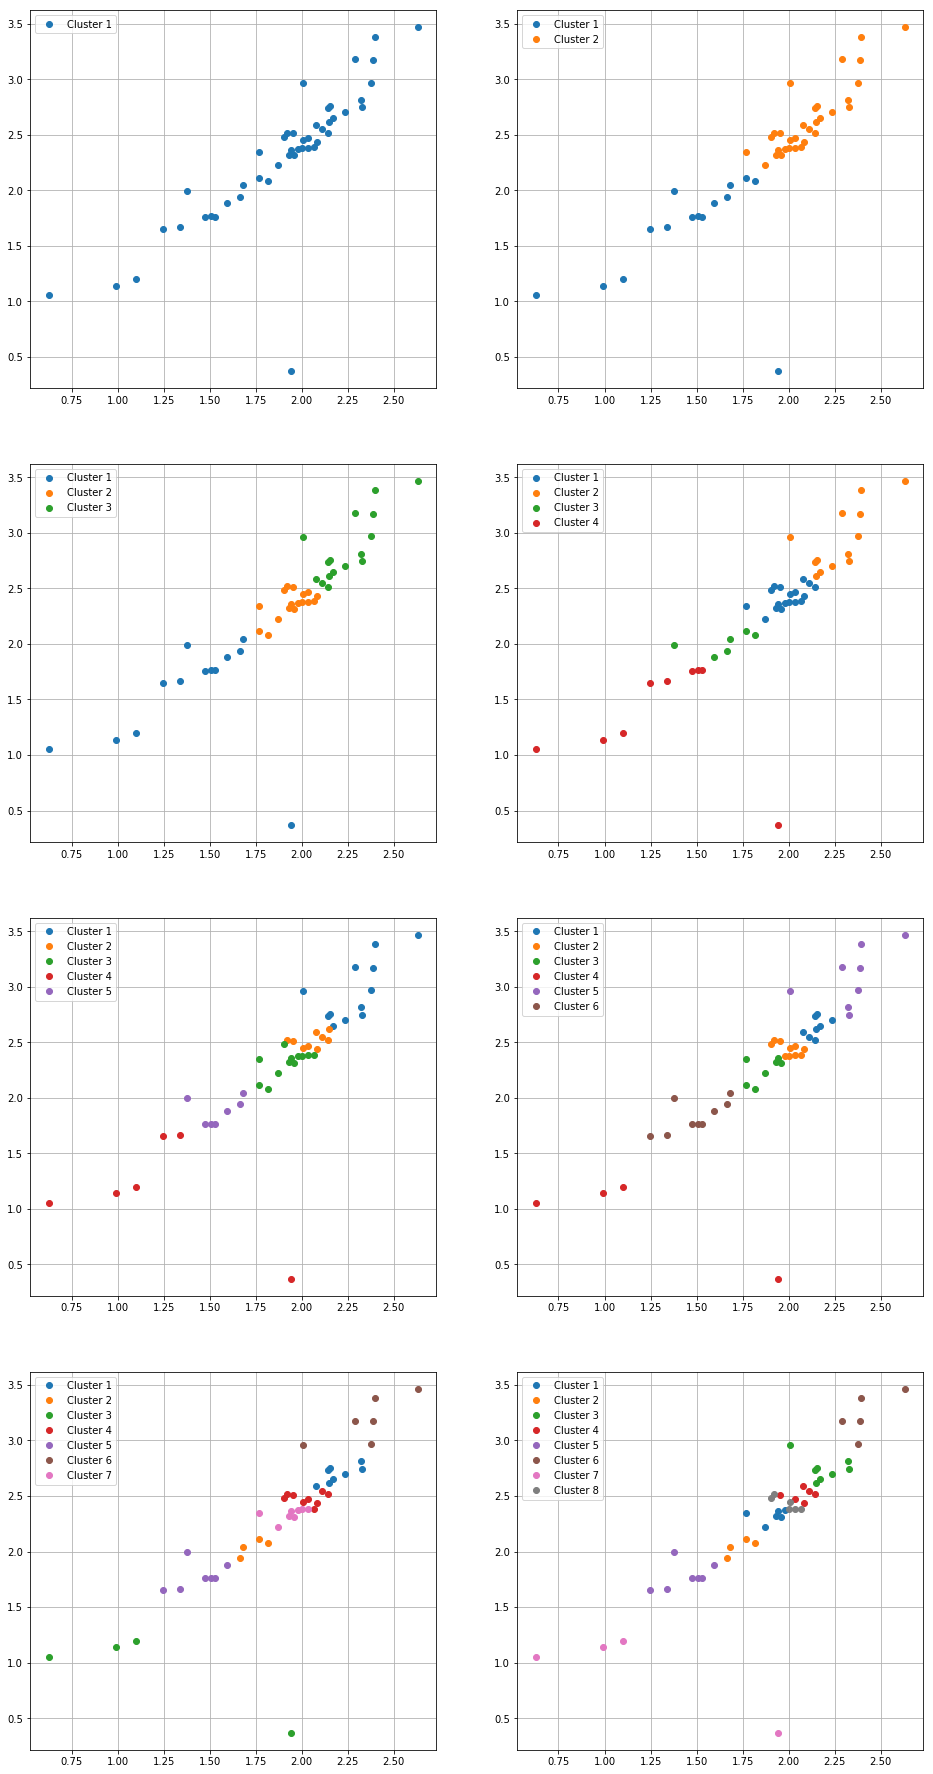

In [8]:
mfs = plot_FCM_results(Q, max_clusters=8)

Reference: https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/cmeans.html

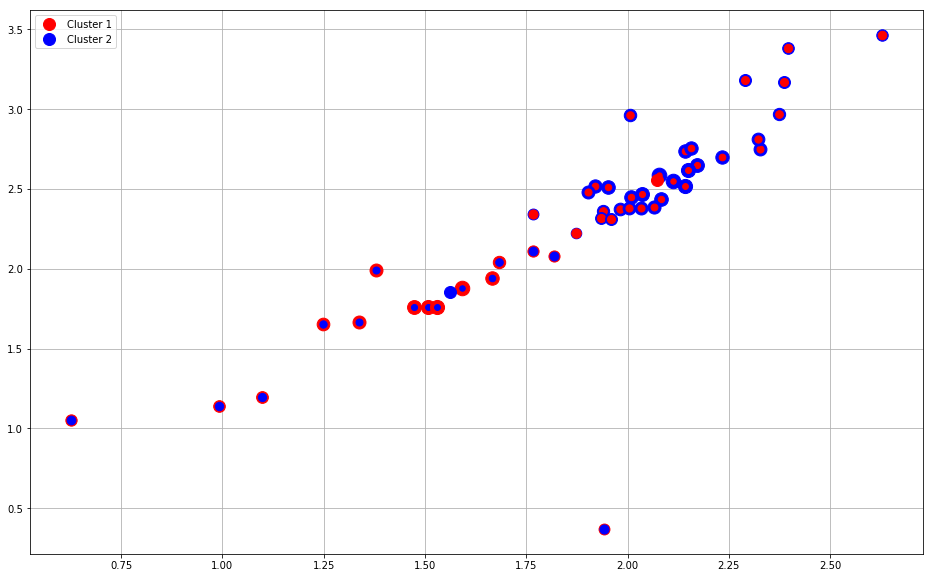

In [32]:
plt.figure(figsize=(16, 10))

data_ = Q
MIN_size, MAX_size = 5, 15
classes, centers, u, errors = FCM(data_, clusters=2, tol=1e-1, max_iter=100, power=2)

for v1, v2, c1, c2, cl in zip(data_[:, 0], data_[:, 1], u[:, 0], u[:, 1], classes):
    
    size_1 = c1 * (MAX_size - MIN_size) + MIN_size
    size_2 = (1 - c1) * (MAX_size - MIN_size) + MIN_size
    
    if size_1 >= size_2:
        plt.plot(v1, v2, 'bo', markersize=size_1)
        plt.plot(v1, v2, 'ro', markersize=size_2)
        
    else:
        plt.plot(v1, v2, 'ro', markersize=size_2)
        plt.plot(v1, v2, 'bo', markersize=size_1)

plt.plot(centers[0, 0], centers[0, 1], 'ro', label='Cluster 1', markersize=12)
plt.plot(centers[1, 0], centers[1, 1], 'bo', label='Cluster 2', markersize=12)        

plt.legend()
plt.grid()
plt.show()

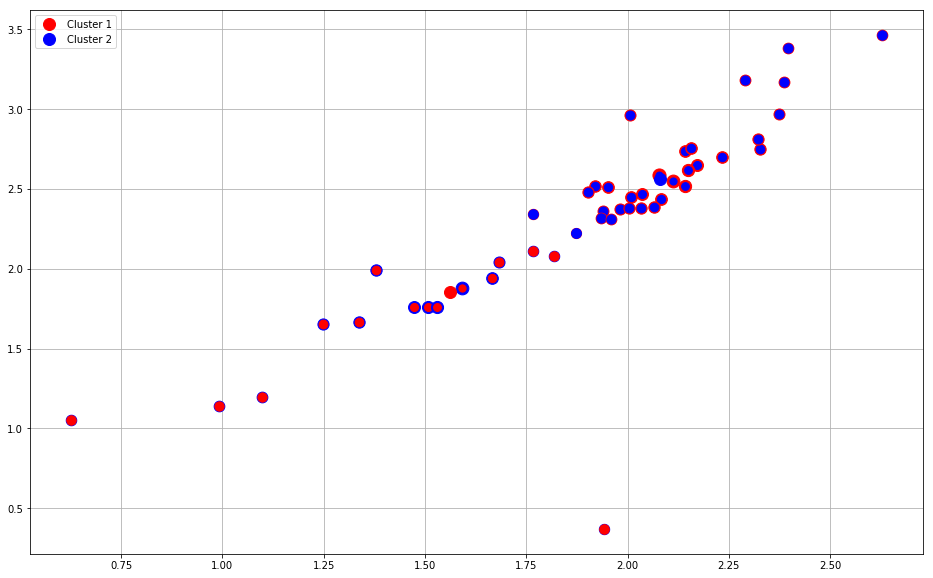

In [33]:
plt.figure(figsize=(16, 10))

data_ = Q
MIN_size, MAX_size = 5, 15
classes, centers, u, errors = FCM(data_, clusters=2, tol=1e-1, max_iter=100, power=5)

for v1, v2, c1, c2, cl in zip(data_[:, 0], data_[:, 1], u[:, 0], u[:, 1], classes):
    
    size_1 = c1 * (MAX_size - MIN_size) + MIN_size
    size_2 = (1 - c1) * (MAX_size - MIN_size) + MIN_size
    
    if size_1 >= size_2:
        plt.plot(v1, v2, 'bo', markersize=size_1)
        plt.plot(v1, v2, 'ro', markersize=size_2)
        
    else:
        plt.plot(v1, v2, 'ro', markersize=size_2)
        plt.plot(v1, v2, 'bo', markersize=size_1)

plt.plot(centers[0, 0], centers[0, 1], 'ro', label='Cluster 1', markersize=12)
plt.plot(centers[1, 0], centers[1, 1], 'bo', label='Cluster 2', markersize=12)        

plt.legend()
plt.grid()
plt.show()

In [10]:
from IPython.display import Image

In [11]:
!cat Lab_9.m

function [] = Lab_9()
    data = xlsread("data_nums.xlsx");
    [centers,U] = fcm(data, 3);

    maxU = max(U);
    index1 = find(U(1,:) == maxU);
    index2 = find(U(2,:) == maxU);
    index3 = find(U(3,:) == maxU);
    
    plot(data(index1,1),data(index1,2),'ob')
    hold on
    plot(data(index2,1),data(index2,2),'or')
    plot(data(index3,1),data(index3,2),'og')
    plot(centers(1,1),centers(1,2),'xb','MarkerSize',15,'LineWidth',3)
    plot(centers(2,1),centers(2,2),'xr','MarkerSize',15,'LineWidth',3)
    plot(centers(3,1),centers(3,2),'xg','MarkerSize',15,'LineWidth',3)
    hold off
end

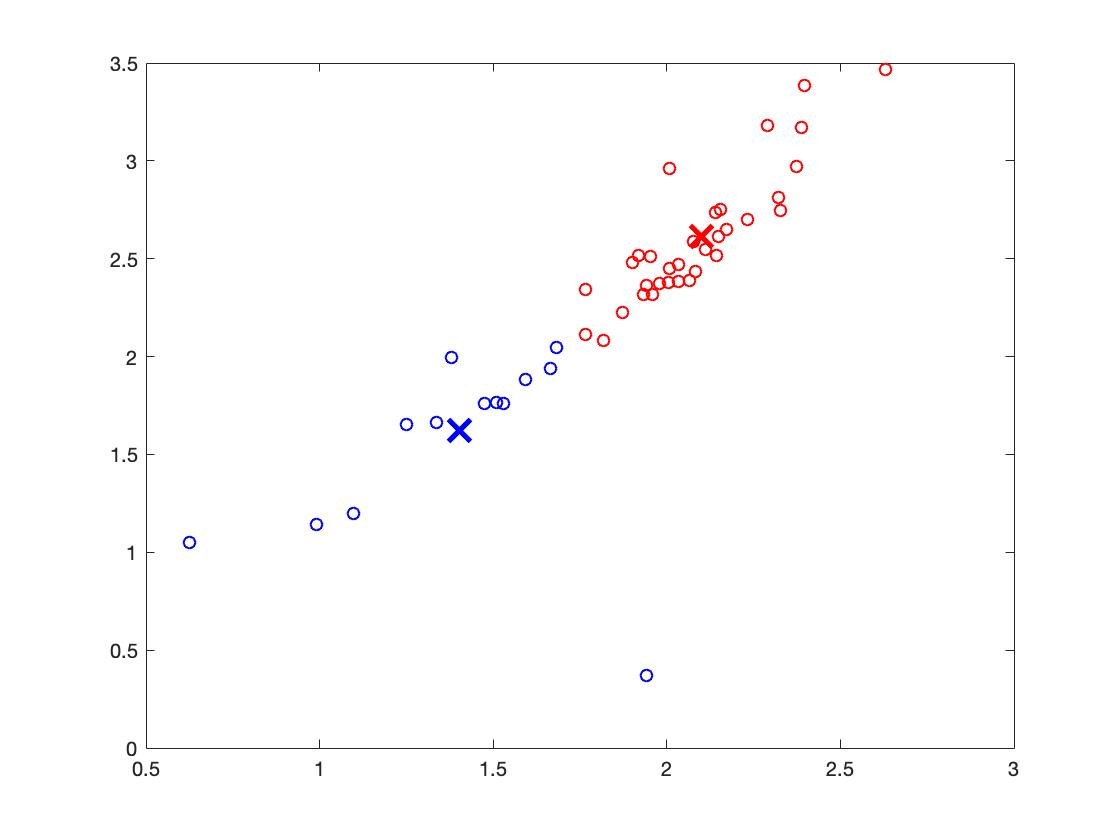

In [12]:
Image(filename='matlab_results_2.jpg')

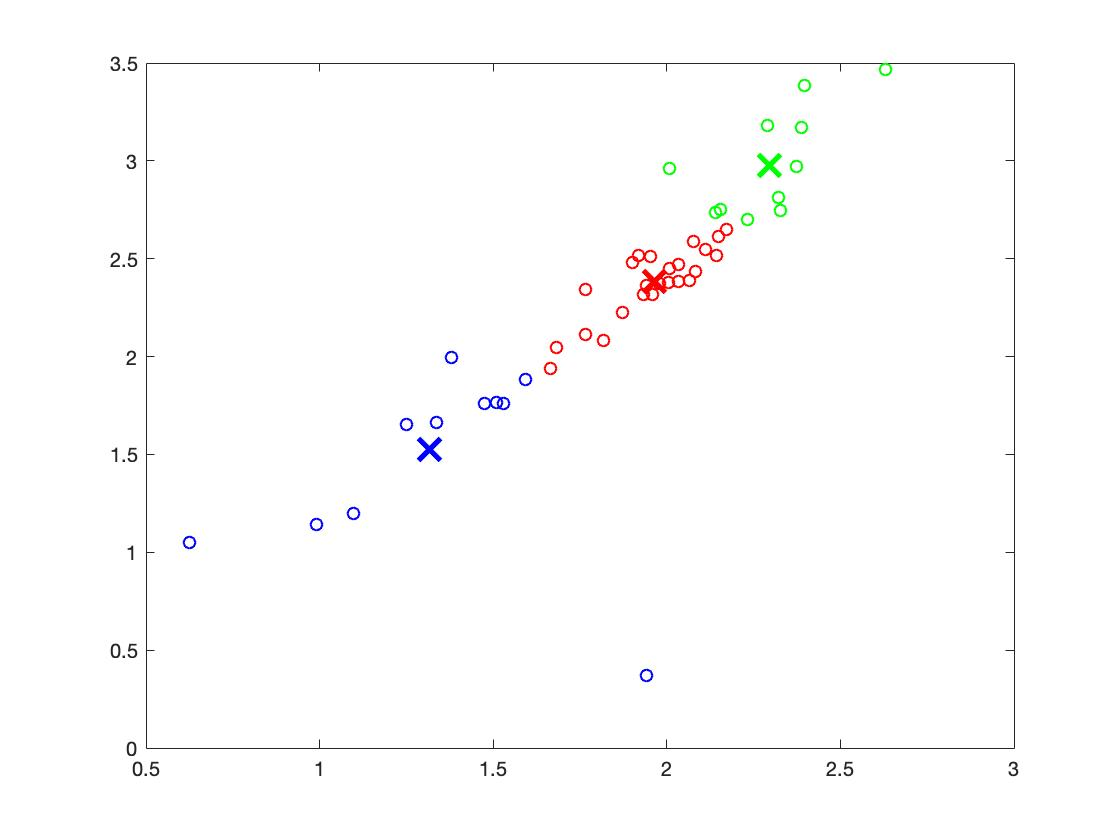

In [13]:
Image(filename='matlab_results_3.jpg')

In [14]:
P1 = data.values[:, 0]
P2 = data.values[:, 1]
CL1, CL2 = mfs[1][1][:, 0], mfs[1][1][:, 1]

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
regr = RandomForestRegressor()

In [17]:
data_input = np.column_stack((P1, P2))
data_output = np.column_stack((CL1, CL2))

In [18]:
regr = regr.fit(data_input, data_output)

/home/hegnatin/projects/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
min_1, min_2, max_1, max_2 = np.min(P1), np.min(P2), np.max(P1), np.max(P2)

In [20]:
print(min_1, max_1, min_2, max_2)

0.625836272 2.628949267 0.369396864 3.465202188


In [21]:
P1_in = np.linspace(min_1, max_1, num=50)
P2_in = np.linspace(min_2, max_2, num=50)
P_in = np.column_stack((P1_in, P2_in))

In [22]:
output = regr.predict(P_in)
CL1_out, CL2_out = output[:, 0], output[:, 1]

In [23]:
P1, P2 = np.meshgrid(P1_in, P2_in)
CL1, CL2 = np.meshgrid(CL1_out, CL2_out)

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

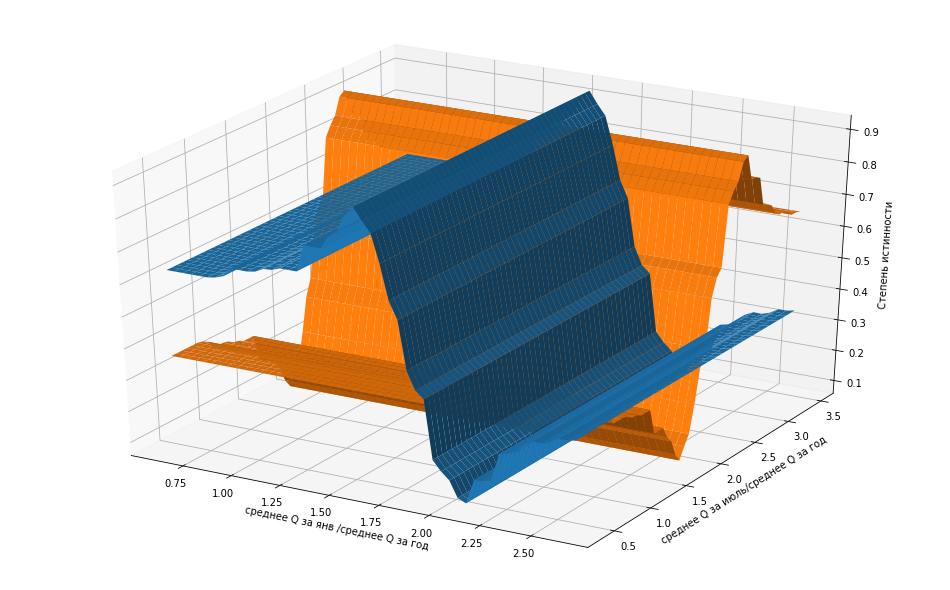

In [25]:
axs = Axes3D(plt.figure(figsize=(13, 8)))
axs.plot_surface(P1, P2, CL1)
axs.plot_surface(P1, P2, CL2)
axs.set_xlabel('среднее Q за янв /среднее Q за год')
axs.set_ylabel('среднее Q за июль/среднее Q за год')
axs.set_zlabel('Степень истинности')
plt.show()